Use this dataset of airline arrival information to predict how late flights will be. A flight only counts as late if it is more than 30 minutes late.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as sklearn_pca
from sklearn import decomposition
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE

In [3]:
# Read and import data
airlines = pd.read_csv('Airlines 2008.csv')
airlines.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [4]:
#Change the ArrDelay variable into a categorical variable
airlines.loc[airlines['ArrDelay'] <= 30, 'ArrDelay'] = 0
airlines.loc[airlines['ArrDelay'] > 30, 'ArrDelay'] = 1

In [5]:
#Check length of the dataset
len(airlines)

7009728

In [6]:
#Type of info per column of the dataset
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            int64
CancellationCode     object
Diverted             int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: float64(14), int64(10), object(5)
memory usage: 1.5+ GB


In [7]:
#Substitute infinity and Nan values by Zeros and check that no Nans are left
airlines = airlines.replace([np.inf, -np.inf], np.nan)
airlines = airlines.fillna(0)   
print(airlines.isnull().sum())
print(airlines.info())

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
CancellationCode     0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime    

In [8]:
#Drop "object" type features as they are not going to add information to the model
airlines = airlines.drop(airlines[['UniqueCarrier', 'TailNum','Origin','Dest','CancellationCode']],axis=1)

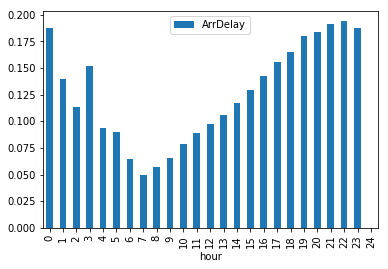

In [9]:
# Compute average number of delayed flights per hour
airlines['hour'] = airlines['CRSArrTime'].map(lambda x: int(str(int(x)).zfill(4)[:2]))
grouped = airlines[['ArrDelay', 'hour' ]].groupby('hour').mean()

# plot average delays by hour
grouped.plot(kind='bar')

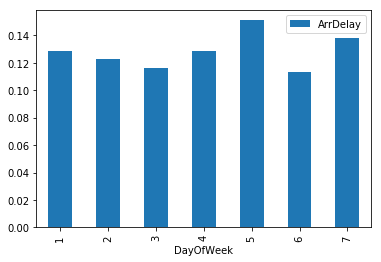

In [10]:
# Compute average number of delayed flights per day of the month
grouped = airlines[['ArrDelay', 'DayOfWeek']].groupby('DayOfWeek').mean()

# plot average delays by day of the month
grouped.plot(kind='bar')

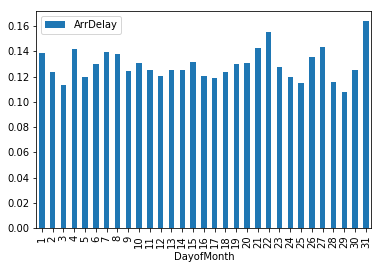

In [11]:
# Compute average number of delayed flights per day
grouped = airlines[['ArrDelay', 'DayofMonth']].groupby('DayofMonth').mean()

# plot average delays by day
grouped.plot(kind='bar')

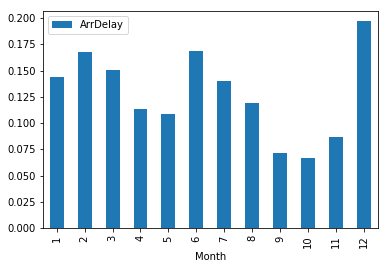

In [12]:
# Compute average number of delayed flights per month
grouped = airlines[['ArrDelay', 'Month']].groupby('Month').mean()

# plot average delays by month
grouped.plot(kind='bar')

In [13]:

XA= airlines.drop('ArrDelay',axis=1)
yA = airlines['ArrDelay']


#Preprocess and scale data
names = XA.columns
XA_scaled = pd.DataFrame(preprocessing.scale(XA), columns = names)
summary = XA_scaled.describe()
XA_scaled.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,hour
0,0.0,-1.577794,-1.446848,0.038133,1.368427,1.354686,1.399788,1.512824,-0.963035,0.048515,...,-0.544551,-0.710139,-0.141415,-0.04969,-0.173255,-0.071994,-0.226623,-0.019013,-0.223486,1.520908
1,0.0,-1.577794,-1.446848,0.038133,-1.090467,-1.273203,-0.821755,-1.025128,0.513224,0.048515,...,-0.343789,-0.535472,-0.141415,-0.04969,-0.173255,-0.071994,-0.226623,-0.019013,-0.223486,-0.965033
2,0.0,-1.577794,-1.446848,0.038133,-1.338521,-1.520914,-1.185581,-1.543077,-0.905432,-0.396643,...,-0.745313,0.075863,-0.141415,-0.04969,-0.173255,-0.071994,-0.226623,-0.019013,-0.223486,-1.586519
3,0.0,-1.577794,-1.446848,0.038133,-0.751852,-0.853172,-0.726205,-0.817948,-0.243766,-0.507932,...,-0.745313,-0.797473,-0.141415,-0.04969,-0.173255,-0.071994,-0.226623,-0.019013,-0.223486,-0.757872
4,0.0,-1.577794,-1.446848,0.038133,1.025875,0.923885,0.936737,0.891285,0.864447,-0.480110,...,-0.745313,-0.535472,-0.141415,-0.04969,-0.072252,-0.071994,-0.226623,-0.019013,1.359403,0.899423


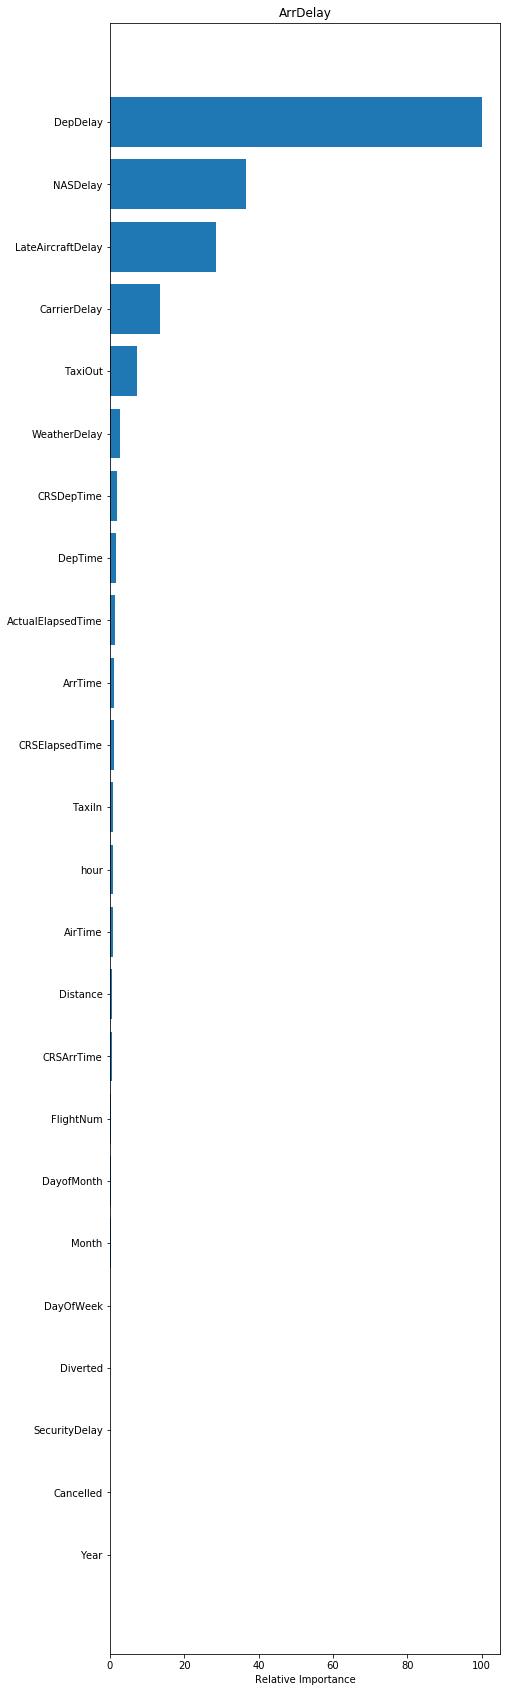

In [14]:
#Calculate Feature Importance using Random Forest
rf = RandomForestClassifier()
rf.fit(XA_scaled, yA)

#Define feature importance
feature_importance8 = rf.feature_importances_

# Make importances relative to max importance.
feature_importance8 = 100.0 * (feature_importance8 / feature_importance8.max())
sorted_idx = np.argsort(feature_importance8)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(7, 30))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance8[sorted_idx], align='center')
plt.yticks(pos, XA_scaled.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('ArrDelay')
plt.show()

In [15]:
#Feature Selection. Scores for the most relevant features (should we start with the one that has more explanatory power)
from sklearn.feature_selection import SelectKBest

# feature extraction
test = SelectKBest()
fit = test.fit(XA_scaled, yA)

#Identify features with highest score from a predictive perspective (for all programs)
names2 = XA_scaled.columns
Bestfeatures = pd.DataFrame(fit.scores_, index = names2)
Bestfeatures.columns = ['Best Features']
Bestfeatures.sort_values(by=['Best Features'], ascending=False)

D:\Users\Borja.gonzalez\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [0] are constant.
  UserWarning)
D:\Users\Borja.gonzalez\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,Best Features
DepDelay,6.130577e+06
LateAircraftDelay,2.423769e+06
NASDelay,1.663857e+06
CarrierDelay,1.144760e+06
TaxiOut,6.582422e+05
DepTime,2.823716e+05
WeatherDelay,2.184958e+05
CRSDepTime,1.223980e+05
CRSArrTime,1.138275e+05
hour,1.136526e+05


In [29]:
#From Feature selection, we´ll only keep the most meaningful features 
fs = ['DepDelay','NASDelay','LateAircraftDelay','CarrierDelay','TaxiOut','WeatherDelay']

#From Recursive Feature Elimination - considering from Feature selection WeatherDelay only DepTime has been included in the list
rfe = ['DepDelay', 'LateAircraftDelay', 'NASDelay', 'CarrierDelay', 'TaxiOut', 'DepTime', 'WeatherDelay']

#From Features Selection and PCA analysis (only three features are meaningful+ArrDelay)
fps = ['ArrDelay','NASDelay','LateAircraftDelay','CarrierDelay','TaxiOut']

#Set up the new dataset based on the meaningful features
airlines2=airlines[fps]

In [30]:
#Check the new dataset
airlines2.head()

,ArrDelay,NASDelay,LateAircraftDelay,CarrierDelay,TaxiOut
0,0.0,0.0,0.0,0.0,8.0
1,0.0,0.0,0.0,0.0,10.0
2,0.0,0.0,0.0,0.0,17.0
3,0.0,0.0,0.0,0.0,7.0
4,1.0,0.0,32.0,2.0,10.0


In [31]:
#Count number of datapoints for ArrDelay
airlines2['ArrDelay'].value_counts()

0.0    6108330
1.0     901398
Name: ArrDelay, dtype: int64

In [32]:
#Downsample majority class (due to computational restrictions we downsample the majority instead of upsampling the minority)

# Separate majority and minority classes
airlines_majority = airlines2[airlines2.ArrDelay==0]
airlines_minority = airlines2[airlines2.ArrDelay==1]
 
# Downsample airlines majority
airlines_majority_downsampled = resample(airlines_majority, replace=False, n_samples=901398, random_state=123) 
 
# Combine minority class with downsampled majority class
airlines_downsampled = pd.concat([airlines_majority_downsampled, airlines_minority])
 
# Display new class counts
airlines_downsampled.ArrDelay.value_counts()

1.0    901398
0.0    901398
Name: ArrDelay, dtype: int64

In [33]:
#Preprocess and scale data to fit into the models
airlines_downsampled2=airlines_downsampled.drop('ArrDelay',axis=1)

names = airlines_downsampled2.columns
X2 = pd.DataFrame(preprocessing.scale(airlines_downsampled2), columns = names)
X2.describe()

,NASDelay,LateAircraftDelay,CarrierDelay,TaxiOut
count,1.802796e+06,1.802796e+06,1.802796e+06,1.802796e+06
mean,-2.033507e-12,3.680095e-12,3.222554e-12,2.195154e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.872791e-01,-4.269176e-01,-3.112424e-01,-1.143078e+00
25%,-3.872791e-01,-4.269176e-01,-3.112424e-01,-5.097678e-01
50%,-3.872791e-01,-4.269176e-01,-3.112424e-01,-2.794733e-01
75%,-1.233784e-01,-1.043743e-01,-3.112424e-01,1.235420e-01
max,4.437687e+01,3.494533e+01,6.470832e+01,2.355600e+01


In [34]:
#Define Outcome & Predictors

y = airlines_downsampled['ArrDelay']
X2 = airlines_downsampled2

#Split into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=42)

#KFold for cross validation analysis
kf = KFold(5)

***PCA Analysis***

In [35]:
# Build up the correlation mtrix
Z = X2
correlation_matrix = Z.corr()

In [36]:
#Eigenvectores & Eigenvalues

eig_vals, eig_vecs = np.linalg.eig(correlation_matrix)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_vals)):
    eigvecs = eig_vecs[:, i].reshape(1, len(Z.columns)).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvecs))
    print('Eigenvalue {}: {}'.format(i + 1, eig_vals[i]))
    print(40 * '-')


sklearn_pca = PCA(n_components=len(Z.columns))
Y_sklearn = sklearn_pca.fit_transform(correlation_matrix)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

Eigenvector 1: 
[[ 0.70678189]
 [ 0.05769545]
 [ 0.08956076]
 [-0.69936361]]
Eigenvalue 1: 0.5045882148054732
----------------------------------------
Eigenvector 2: 
[[ 0.70728803]
 [-0.05544325]
 [-0.0696255 ]
 [ 0.7013002 ]]
Eigenvalue 2: 1.494707745197884
----------------------------------------
Eigenvector 3: 
[[ 0.01110481]
 [-0.7062395 ]
 [-0.69469815]
 [-0.1360034 ]]
Eigenvalue 3: 0.9443270992113003
----------------------------------------
Eigenvector 4: 
[[ 0.00892603]
 [ 0.7034366 ]
 [-0.71029968]
 [-0.02390907]]
Eigenvalue 4: 1.0563769407853416
----------------------------------------
The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [  5.49751227e-01   3.65191065e-01   8.50577081e-02   1.59576453e-33]


In [41]:
#PCA Analysis

# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the features and transform
X_std = sc.fit_transform(X2)

# Create a PCA object
pca = decomposition.PCA(n_components=3)

# Fit the PCA and transform the data
X_std_pca = pca.fit_transform(X_std)

# View the new feature data's shape
X_std_pca.shape

# Create a new dataframe with the new features

XPCA = pd.DataFrame(X_std_pca)
XPCA.head()


,0,1,2
0,-0.586078,0.070503,-0.582755
1,0.122815,0.072873,-0.543100
2,-0.586078,0.070503,-0.582755
3,-0.545702,0.071879,-0.574925
4,-0.707207,0.066373,-0.606246


***Logistic Regression***

In [42]:
# Initialize and fit the model.
lr = LogisticRegression()
fittrain = lr.fit(X_train,y_train)
fittest = lr.fit(X_test,y_test)

# Predict on training set
predtrain_y = lr.predict(X_train)
predtest_y = lr.predict(X_test)

In [43]:
from sklearn.metrics import classification_report

#Training Scores
target_names = ['0.0', '1.0']
print(classification_report(y_train, predtrain_y, target_names=target_names))
cnf = confusion_matrix(y_train, predtrain_y)
print(cnf)

# Accuracy tables.
table_train = pd.crosstab(y_train, predtrain_y, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

             precision    recall  f1-score   support

        0.0       0.96      0.96      0.96    631255
        1.0       0.96      0.96      0.96    630702

avg / total       0.96      0.96      0.96   1261957

[[605778  25477]
 [ 24107 606595]]
Training set accuracy:
Percent Type I errors: 0.0201884850276198
Percent Type II errors: 0.019102869590643737




In [44]:
#Testing Scores
target_names = ['0.0', '1.0']
print(classification_report(y_test, predtest_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtest_y)
print(cnf)

table_test = pd.crosstab(y_test, predtest_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))
print(cross_val_score(lr,X2,y,cv=kf))
print(cross_val_score(lr,X2,y,cv=kf).mean())
print('Cross validation PCA:', cross_val_score(lr,XPCA,y,cv=kf).mean())

             precision    recall  f1-score   support

        0.0       0.96      0.96      0.96    270143
        1.0       0.96      0.96      0.96    270696

avg / total       0.96      0.96      0.96    540839

[[258976  11167]
 [ 10493 260203]]
Test set accuracy:
Percent Type I errors: 0.02064754945556811
Percent Type II errors: 0.019401337551470957
[ 0.94001276  0.94113585  0.95913845  0.95925216  0.96016463]
0.951940769742
Cross validation PCA: 0.912000577548


*** Random Forest***

In [45]:
# Train model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.fit(X_test, y_test)

# Predict on training set
predtrainrf_y = rf.predict(X_train)
predtestrf_y = rf.predict(X_test)

In [46]:
#Training Scores
target_names = ['0', '1']
print(classification_report(y_train, predtrainrf_y, target_names=target_names))
cnf = confusion_matrix(y_train, predtrainrf_y)
print(cnf)

# Accuracy tables.
table_train = pd.crosstab(y_train, predtrainrf_y, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98    631255
          1       0.99      0.97      0.98    630702

avg / total       0.98      0.98      0.98   1261957

[[627623   3632]
 [ 20208 610494]]
Training set accuracy:
Percent Type I errors: 0.0028780695380270483
Percent Type II errors: 0.016013223905410406




In [47]:
#Test Scores
target_names = ['0', '1']
print(classification_report(y_test, predtestrf_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtestrf_y)
print(cnf)

table_test = pd.crosstab(y_test, predtestrf_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))
print(cross_val_score(rf,X2,y,cv=kf))
print(cross_val_score(rf,X2,y,cv=kf).mean())
print('Cross validation PCA:', cross_val_score(rf,XPCA,y,cv=kf).mean())

             precision    recall  f1-score   support

          0       0.97      1.00      0.98    270143
          1       1.00      0.97      0.98    270696

avg / total       0.98      0.98      0.98    540839

[[269460    683]
 [  7890 262806]]
Test set accuracy:
Percent Type I errors: 0.0012628527158729307
Percent Type II errors: 0.014588444990098717
[ 0.99108054  0.99123306  0.97978972  0.96799692  0.96700124]
0.979446364568
Cross validation PCA: 0.973926050712


***Naive - Bayes***

In [48]:
# Train model
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
bnb.fit(X_test, y_test)

# Predict on training set
predtrainbnb_y = bnb.predict(X_train)
predtestbnb_y = bnb.predict(X_test)

In [49]:
#Training Scores
target_names = ['0', '1']
print(classification_report(y_train, predtrainbnb_y, target_names=target_names))
cnf = confusion_matrix(y_train, predtrainbnb_y)
print(cnf)

# Accuracy tables.
table_train = pd.crosstab(y_train, predtrainbnb_y, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

             precision    recall  f1-score   support

          0       0.98      0.90      0.94    631255
          1       0.91      0.98      0.94    630702

avg / total       0.94      0.94      0.94   1261957

[[568219  63036]
 [ 10919 619783]]
Training set accuracy:
Percent Type I errors: 0.04995098882133068
Percent Type II errors: 0.008652434274701911




In [50]:
#Test Scores
target_names = ['0', '1']
print(classification_report(y_test, predtestbnb_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtestbnb_y)
print(cnf)

table_test = pd.crosstab(y_test, predtestbnb_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))
print(cross_val_score(bnb,X2,y,cv=kf))
print(cross_val_score(bnb,X2,y,cv=kf).mean())
print('Cross validation PCA:', cross_val_score(bnb,XPCA,y,cv=kf).mean())

             precision    recall  f1-score   support

          0       0.98      0.90      0.94    270143
          1       0.91      0.98      0.94    270696

avg / total       0.94      0.94      0.94    540839

[[242760  27383]
 [  4793 265903]]
Test set accuracy:
Percent Type I errors: 0.05063059431734768
Percent Type II errors: 0.008862156760144886
[ 0.89979199  0.89987214  0.93973524  0.98310679  0.98314284]
0.941129801341
Cross validation PCA: 0.81778745256


***Gradient Boosting Classifier***

In [51]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
clf.fit(X_test, y_test)

# Predict on training set
predtrainclf_y = clf.predict(X_train)
predtestclf_y = clf.predict(X_test)

In [52]:
#Training Scores
target_names = ['0.0', '1.0']
print(classification_report(y_train, predtrainclf_y, target_names=target_names))
cnf = confusion_matrix(y_train, predtrainclf_y)
print(cnf)

# Accuracy tables.
table_train = pd.crosstab(y_train, predtrainclf_y, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98    631255
        1.0       0.99      0.96      0.97    630702

avg / total       0.98      0.97      0.97   1261957

[[622078   9177]
 [ 22468 608234]]
Training set accuracy:
Percent Type I errors: 0.007272038587685634
Percent Type II errors: 0.017804093166407412




In [53]:
#Test Scores
target_names = ['0.0', '1.0']
print(classification_report(y_test, predtestclf_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtestclf_y)
print(cnf)

table_test = pd.crosstab(y_test, predtestclf_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))
print(cross_val_score(clf,X2,y,cv=kf))
print(cross_val_score(clf,X2,y,cv=kf).mean())
print('Cross validation PCA:', cross_val_score(clf,XPCA,y,cv=kf).mean())

             precision    recall  f1-score   support

        0.0       0.96      0.99      0.97    270143
        1.0       0.98      0.96      0.97    270696

avg / total       0.97      0.97      0.97    540839

[[266102   4041]
 [  9747 260949]]
Test set accuracy:
Percent Type I errors: 0.007471724487324324
Percent Type II errors: 0.01802199915316758
[ 0.97691092  0.97695523  0.97417344  0.95862258  0.95975971]
0.969284374035
Cross validation PCA: 0.949109049962


***LDA Classifier***

In [54]:
# LDA Classification

lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train)
lda.fit(X_test, y_test)

# Predict on training set
predtrainlda_y = lda.predict(X_train)
predtestlda_y = lda.predict(X_test)

In [55]:
#Training Scores
target_names = ['0.0', '1.0']
print(classification_report(y_train, predtrainlda_y, target_names=target_names))
cnf = confusion_matrix(y_train, predtrainlda_y)
print(cnf)

# Accuracy tables.
table_train = pd.crosstab(y_train, predtrainlda_y, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

             precision    recall  f1-score   support

        0.0       0.80      0.99      0.89    631255
        1.0       0.99      0.76      0.86    630702

avg / total       0.90      0.88      0.87   1261957

[[627480   3775]
 [152586 478116]]
Training set accuracy:
Percent Type I errors: 0.0029913856018865936
Percent Type II errors: 0.12091220223826961




In [56]:
#Test Scores
target_names = ['0.0', '1.0']
print(classification_report(y_test, predtestlda_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtestlda_y)
print(cnf)

table_test = pd.crosstab(y_test, predtestlda_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))
print(cross_val_score(lda,X2,y,cv=kf))
print(cross_val_score(lda,X2,y,cv=kf).mean())
print('Cross validation PCA:', cross_val_score(lda,XPCA,y,cv=kf).mean())

             precision    recall  f1-score   support

        0.0       0.80      0.99      0.89    270143
        1.0       0.99      0.76      0.86    270696

avg / total       0.90      0.88      0.87    540839

[[268470   1673]
 [ 65701 204995]]
Test set accuracy:
Percent Type I errors: 0.0030933420112085113
Percent Type II errors: 0.12147977494226563
[ 0.96004548  0.96051686  0.87697159  0.61111774  0.63918804]
0.809567943085
Cross validation PCA: 0.787427892843


Before running the model, the data was cleaned. The NaN and values values were replaced by zeros. To run the model and predict the arrival delay, the first thing that was done was to select the most meaningful features.
There was an overfitting problem when DepDelayed was chosen as one of the variables explaining the arrivals delayed. Hence, the following features were selected:

'NASDelay'
'LateAircraftDelay'
'CarrierDelay'
'TaxiOut'

The modesl still present some overfitting as the PCA scores are lower than the scores of the models through crossvalidation but are closer to each other.

To reduce the bias in the classifiers, as the delays and on-time arrivals were unevenly spread in the dataset, the dataset was resampled. In this case and due to the computing power requirements, the majority (on-time arrivals) was downsampled.

The resampled dataset was split into a train and a test dataset at 30% test dataset ratio.

The new dataset was run through different models: Naive Bayes, LDA, RandomForest, Logistic Regression and Gradient Boosting Classifier. Every model was run on a PCA predictors to see the max accuracy that the model was able to obtain through cross validation. 

The model scoring a better result in the test sample was Random Forest scorring 97% and having a reduced % of type I and type II errors in the model. The model scoring the worst result was LDA.

The SVC model was not run (although it was tried) due to computational restrictions. More than 2 hours were required to run it for the first time and the model din´t run through all the data.